<a href="https://colab.research.google.com/github/Sourabh535/Fake-job-posting-prediction/blob/main/Fake_job_posting_predicaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
# import libraries
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from collections import defaultdict
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk import ngrams
import seaborn as sns
import pandas as pd
import numpy as np
import os
import re

In [8]:
#load the dataset
df = pd.read_csv('/content/fake_job_postings.csv')
df.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [9]:
# checking number of observations in the dataset
df.shape

(17880, 18)

In [10]:
# checking data type of the observations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [11]:
# get a descriptive statistical summary of the dataframe.
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
#Exploratory data analysis
# check for duplicate values in dataframe
df.duplicated().sum()

0

In [13]:
# check for null values in dataset
df.isna().sum().sort_values(ascending=False)

salary_range           15012
department             11547
required_education      8105
benefits                7210
required_experience     7050
function                6455
industry                4903
employment_type         3471
company_profile         3308
requirements            2695
location                 346
description                1
job_id                     0
telecommuting              0
has_questions              0
has_company_logo           0
title                      0
fraudulent                 0
dtype: int64

From the above we see, salary_range, department, required_education,benefits,required_experience,function,industry, employment_type,company_profile and the requirements columns have very high percentage of missing value

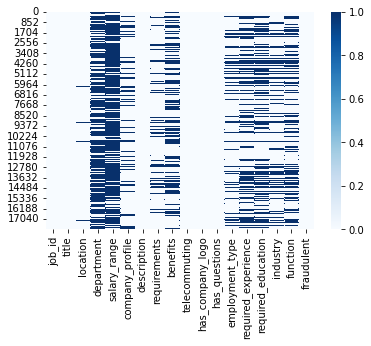

In [14]:
# checking correlation between the data
sns.heatmap(df.isnull(),cmap="Blues")

<ipython-input-15-b3b46e716043>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr , mask=np.zeros_like(corr, dtype=np.bool) , cmap=sns.diverging_palette(-100,0,as_cmap=True) , square = True)


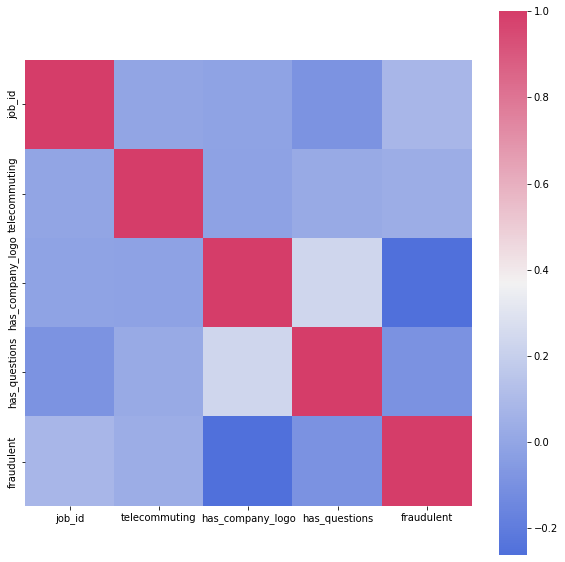

In [15]:
plt.figure(figsize = (10,10))
corr = df.corr()
sns.heatmap(corr , mask=np.zeros_like(corr, dtype=np.bool) , cmap=sns.diverging_palette(-100,0,as_cmap=True) , square = True)

In [16]:
df_1 = df.drop(['job_id' , 'salary_range' , 'telecommuting' , 'has_company_logo' , 'has_questions'] , axis = 1)
df_1['Country'] = df_1['location'].str[:2]
df_1.head(5)

,title,location,department,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function,fraudulent,Country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,Other,Internship,NaN,NaN,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,NaN,NaN,NaN,NaN,NaN,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US


In [17]:
df_1.shape

(17880, 14)

In [18]:
df_1.fillna(" ", inplace=True)
df_1.isnull().sum()

title                  0
location               0
department             0
company_profile        0
description            0
requirements           0
benefits               0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
Country                0
dtype: int64

In [19]:
# Which industry have the maximum number of fake job postings?
df_industry = df_1[df_1['fraudulent']== 1]
df_vc = df_industry.groupby(["industry"]).sum()
df_vc.head(10)

,fraudulent
industry,
,275
Accounting,57
Airlines/Aviation,1
Animation,2
Apparel & Fashion,2
Automotive,5
Banking,3
Biotechnology,4
Broadcast Media,1


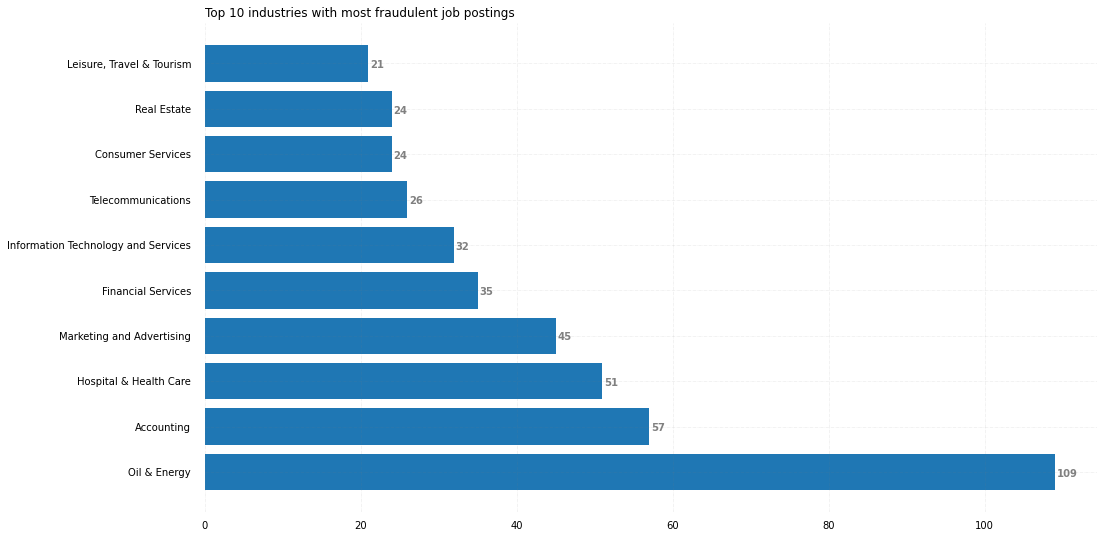

In [20]:
df_vc = df_vc.sort_values(by=['fraudulent'])
dfv = df_vc.tail(11)

x = dfv.index[:-1]
y = dfv["fraudulent"][:-1]

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(x, y)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

# Add Plot Title
ax.set_title('Top 10 industries with most fraudulent job postings',loc ='left',)
plt.show()

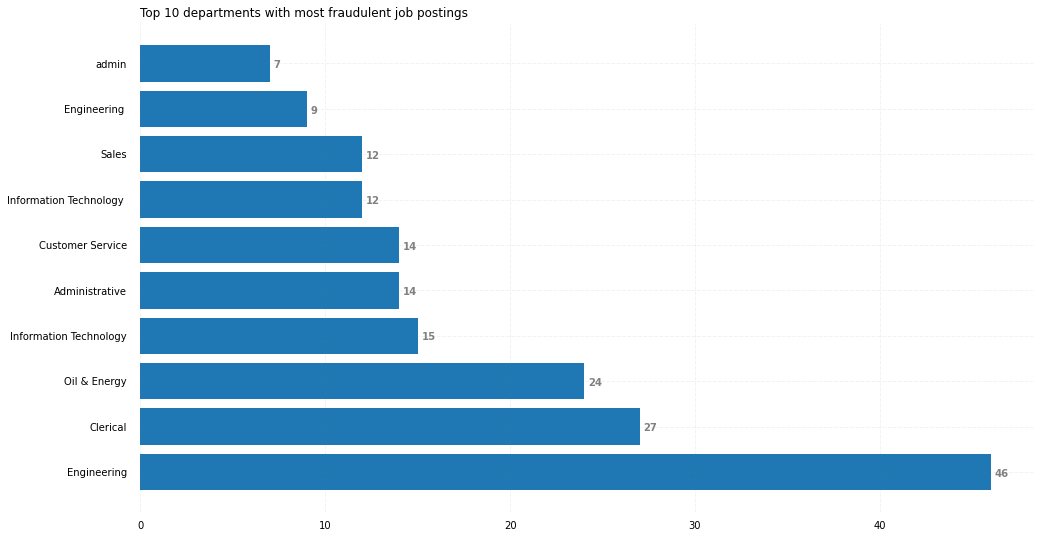

In [21]:
df_vc2 = df_1[df_1['fraudulent']== 1]
df_vc2 = df_vc2.groupby(["department"]).sum()
df_vc2 = df_vc2.sort_values(by=['fraudulent'])
dfv = df_vc2.tail(11)

x = dfv.index[:-1]
y = dfv["fraudulent"][:-1]

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(x, y)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

# Add Plot Title
ax.set_title('Top 10 departments with most fraudulent job postings',loc ='left',)

plt.show()

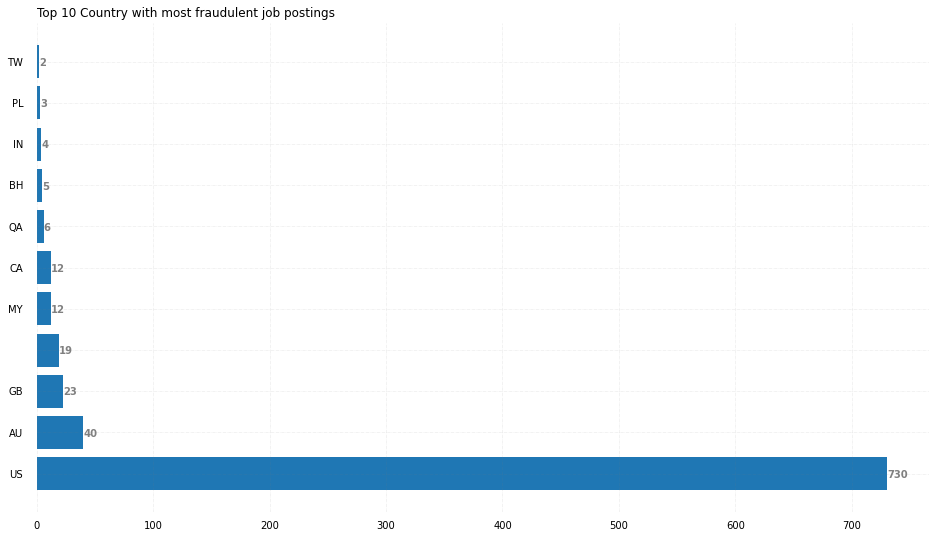

In [22]:
df_vc2 = df_1[df_1['fraudulent']== 1]
df_vc2 = df_vc2.groupby(["Country"]).sum()
df_vc2 = df_vc2.sort_values(by=['fraudulent'])
dfv = df_vc2.tail(11)

x = dfv.index
y = dfv["fraudulent"]

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(x, y)
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

# Add Plot Title
ax.set_title('Top 10 Country with most fraudulent job postings',loc ='left',)

plt.show()

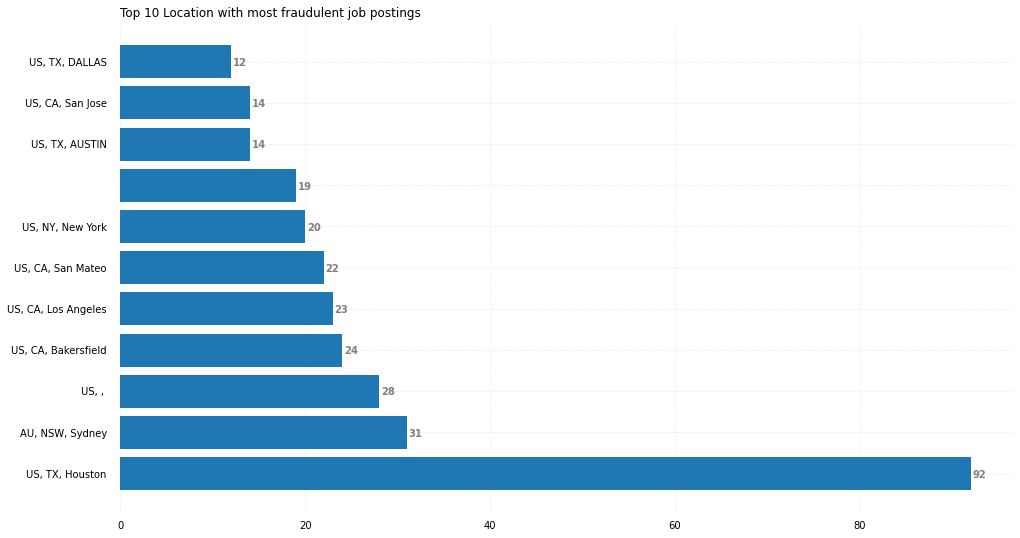

In [23]:
df_vc2 = df_1[df_1['fraudulent']== 1]
df_vc2 = df_vc2.groupby(["location"]).sum()
df_vc2 = df_vc2.sort_values(by=['fraudulent'])
dfv = df_vc2.tail(11)

x = dfv.index
y = dfv["fraudulent"]

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(x, y)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

# Add Plot Title
ax.set_title('Top 10 Location with most fraudulent job postings',loc ='left',)

plt.show()

In [24]:
del df['salary_range']
del df['job_id']
df.fillna(" ",inplace = True)

In [25]:
df['text'] = df['title'] + ' ' + df['location'] + ' ' + df['department'] + ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits'] + ' ' + df['employment_type'] + ' ' + df['required_education'] + ' ' + df['industry'] + ' ' + df['function']
df.text[0]

"Marketing Intern US, NY, New York Marketing We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City. Food52, a fast-growing, James Beard Award-winning online food communi

In [26]:
del df['title']
del df['location']
del df['department']
del df['company_profile']
del df['description']
del df['requirements']
del df['benefits']
del df['employment_type']
del df['required_experience']
del df['required_education']
del df['industry']
del df['function']

In [27]:
df.head(5)

,telecommuting,has_company_logo,has_questions,fraudulent,text
0,0,1,0,0,"Marketing Intern US, NY, New York Marketing We..."
1,0,1,0,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,1,0,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,0,1,0,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,1,1,0,"Bill Review Manager US, FL, Fort Worth SpotS..."


In [28]:
def clean(text):
    text=text.lower()
    obj=re.compile(r"<.*?>")                     #removing html tags
    text=obj.sub(r" ",text)
    obj=re.compile(r"https://\S+|http://\S+")    #removing url
    text=obj.sub(r" ",text)
    obj=re.compile(r"[^\w\s]")                   #removing punctuations
    text=obj.sub(r" ",text)
    obj=re.compile(r"\d{1,}")                    #removing digits
    text=obj.sub(r" ",text)
    obj=re.compile(r"_+")                        #removing underscore
    text=obj.sub(r" ",text)
    obj=re.compile(r"\s\w\s")                    #removing single character
    text=obj.sub(r" ",text)
    obj=re.compile(r"\s{2,}")                    #removing multiple spaces
    text=obj.sub(r" ",text)
   
    
    stemmer = SnowballStemmer("english")
    text=[stemmer.stem(word) for word in text.split() if word not in stop]
    
    return " ".join(text)

In [29]:
def generate(text,ngram):
    n_grams=ngrams(word_tokenize(text),ngram)
    grams=[" ".join(val) for val in n_grams]
    return grams

(-0.5, 799.5, 799.5, -0.5)

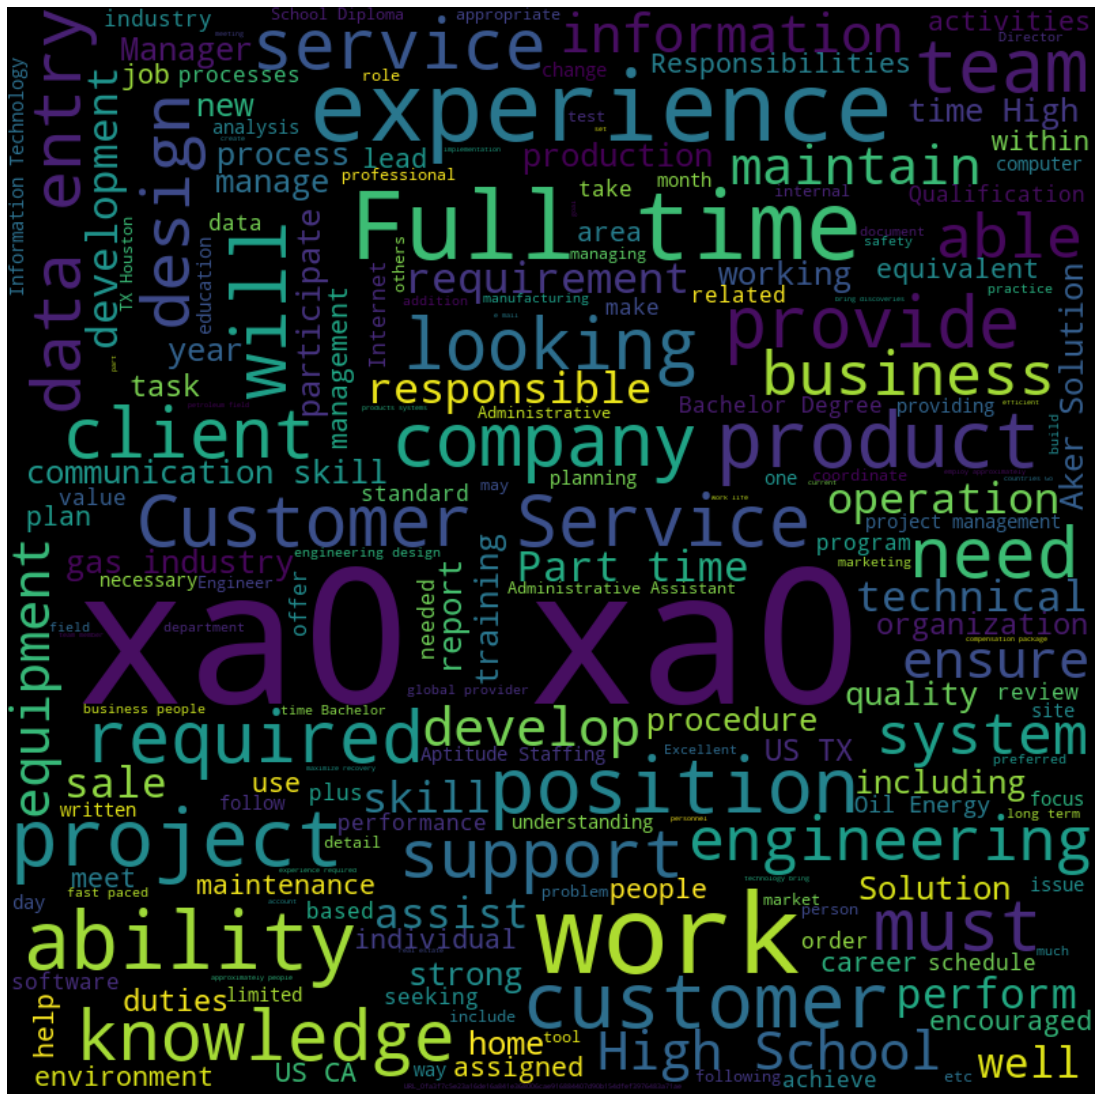

In [30]:
real_job=df[df["fraudulent"]==1]["text"].values
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = STOPWORDS).generate(str(real_job))

fig = plt.figure(figsize = (30,20))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')

In [31]:
!pip install spacy && pyhton -m spacy download en

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/bin/bash: pyhton: command not found


In [44]:
punctuations = str.punctuation

nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

parser = English()


In [45]:
vectorizer=TfidfVectorizer(strip_accents='unicode',
                           analyzer='word',
                           ngram_range=(1, 2),
                           max_features=15000,
                           smooth_idf=True,
                           sublinear_tf=True)

vectorizer.fit(df["text"])
X = vectorizer.transform(df["text"])

In [35]:
y=df["fraudulent"]

X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.20, random_state=42)

In [36]:
model=GaussianNB()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

In [37]:
print(f"Accuracy score: {accuracy_score(y_test,y_pred)}")

Accuracy score: 0.9751118568232662


In [38]:
# Random forest 
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs = 3, oob_score= True, n_estimators = 100, criterion = 'entropy')
model = rfc.fit(X_train, y_train)

In [39]:
print(y_test)

4708     0
11079    0
12357    0
14511    0
16691    0
        ..
10855    0
9827     0
4903     0
6723     0
16899    0
Name: fraudulent, Length: 3576, dtype: int64


In [40]:
pred = rfc.predict(X_test)
score = accuracy_score(y_test, pred)

In [41]:
score

0.9787472035794184

In [42]:
# Create a confusion matrix to check the model accuaracy
print("Classification Report\n")
print(classification_report(y_test, pred))
print("Confusion matrix\n")
print(confusion_matrix(y_test, pred))

Classification Report

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       1.00      0.58      0.73       181

    accuracy                           0.98      3576
   macro avg       0.99      0.79      0.86      3576
weighted avg       0.98      0.98      0.98      3576

Confusion matrix

[[3395    0]
 [  76  105]]


In [43]:
from sklearn import metrics

In [44]:
metrics.f1_score(y_test, pred)



0.7342657342657343